In [7]:
import sys
sys.path.append('..')
# reload local packages automatically
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)

# Import packages.
import cvxpy as cp
import numpy as np

import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
from opentn.states.qubits import get_ladder_operator
lowering = get_ladder_operator()
lowering

DeviceArray([[0.+0.j, 1.+0.j],
             [0.+0.j, 0.+0.j]], dtype=complex128)

2.638300722408311e-07
2.0772161170510943e-07


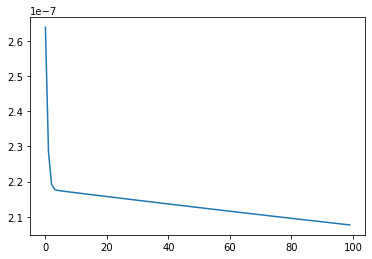

In [163]:
from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, factorize_psd, super2choi
d, N = 2, 4
dim = d**N
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=1e-2)
tau = 4
superops_exp = []
for i, op in enumerate([Lvec, Lvec_odd, Lvec_even]):
    if i == 1:
        superops_exp.append(exp_operator_dt(op, tau/2, 'jax'))
    else:
        superops_exp.append(exp_operator_dt(op, tau, 'jax'))
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = superops_exp

X1, eigvals1 = factorize_psd(psd=super2choi(exp_Lvec_odd), tol=1e-12)
X2, eigvals2 = factorize_psd(psd=super2choi(exp_Lvec_even), tol=1e-12)

from opentn.optimization import gds, frobenius_norm, model_Ys, compute_loss
cost_n4, grads_n4, xi_n4 = gds(fn=compute_loss, x0=[X1, X2, X1], iter=100, loss_fn=frobenius_norm, model=model_Ys, rate=1.5e-9, exact = exp_Lvec, show_cost=False)
print(cost_n4[0])
print(cost_n4[-1])

plt.plot(cost_n4)

In [157]:
print(exp_Lvec_even.shape)
print(np.linalg.matrix_rank(exp_Lvec_even))

(256, 256)
256


In [166]:
from opentn.optimization import model_Zs
from opentn.transformations import lindbladian2super, create_supertensored_from_local
superop = lindbladian2super(Li=[Lnn])
superop = exp_operator_dt(superop, tau/2, 'jax')
gamma = 1e-2
print(np.exp(-tau*gamma/(2*4))), print(np.exp(-tau*gamma/(2*8)))
print(np.sort(np.linalg.eigvals(superop)))

0.9950124791926823
0.9975031223974601
[0.99501248+0.j 0.99750312+0.j 0.99750312+0.j 0.99750312+0.j
 0.99750312+0.j 0.99750312+0.j 0.99750312+0.j 1.        +0.j
 1.        +0.j 1.        +0.j 1.        +0.j 1.        +0.j
 1.        +0.j 1.        +0.j 1.        +0.j 1.        +0.j]


In [168]:
for matrix in [superop, exp_Lvec_odd, exp_Lvec_even, exp_Lvec]:
    print(np.linalg.matrix_rank(super2choi(matrix)))

2
4
2
29


In [133]:
np.sort(eigvals1)[::-1]

array([ 1.59601247e+001,  1.99252079e-002,  1.99252079e-002,
        2.48753638e-005,  4.50856098e-015,  3.96652233e-015,
        3.67215449e-015,  3.45390979e-015,  3.29333088e-015,
        3.27335481e-015,  2.87100045e-015,  2.15063493e-015,
        2.13940053e-015,  1.49491464e-015,  1.37325204e-015,
        1.32187975e-015,  1.12058217e-015,  9.28771162e-016,
        5.68342524e-016,  3.55784551e-016,  3.44475540e-016,
        2.87990870e-016,  2.78315063e-016,  8.17521478e-017,
        2.88454409e-017,  1.43871560e-018,  1.06878237e-018,
        7.18541005e-019,  4.02416294e-019,  1.47797301e-019,
        9.15697476e-021,  1.30551757e-021,  6.81954415e-031,
        5.49093606e-031,  3.41897236e-031,  3.32845778e-031,
        1.96209071e-031,  1.42213044e-031,  1.16527641e-031,
        9.85466571e-032,  6.27415971e-032,  3.33957421e-032,
        1.87824158e-032,  1.64171039e-032,  8.86412729e-033,
        3.95008788e-038,  2.03807148e-038,  3.98118469e-039,
        1.77481294e-039,

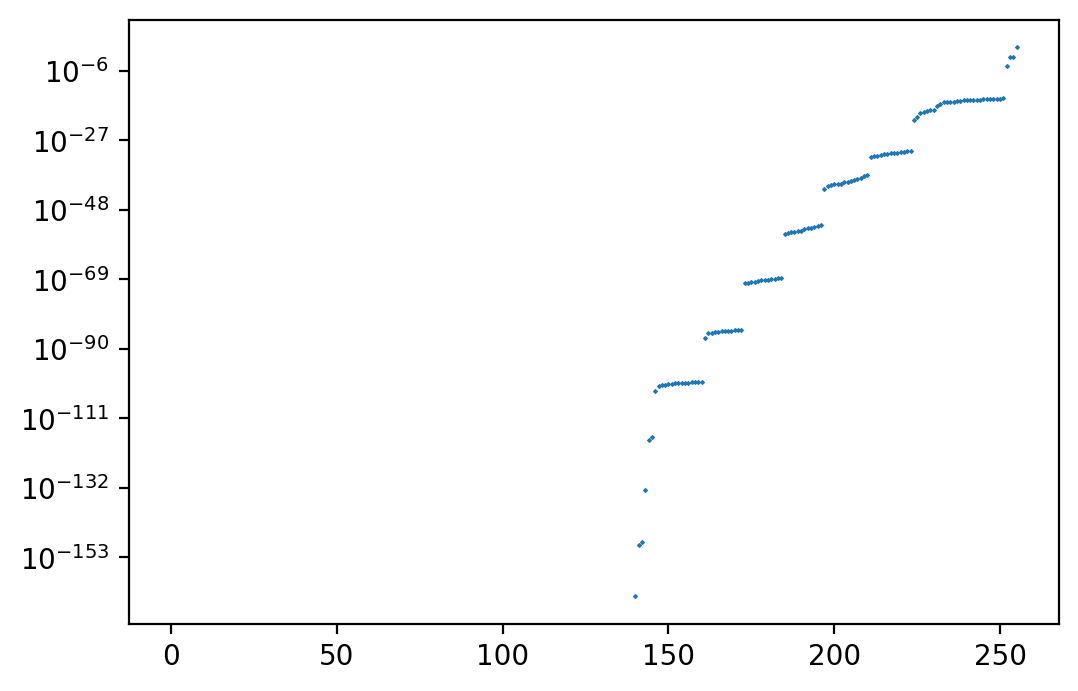

In [131]:
plt.figure(dpi=200)
plt.semilogy(eigvals1, 'x', markersize=1)

In [120]:
np.linalg.matrix_rank(X1)

4

In [118]:
np.linalg.matrix_rank(super2choi(exp_Lvec))

29

In [95]:
if any(x == True for x in np.iscomplex(rhs).flatten()):
    print(True)


In [101]:
np.linalg.norm(Y3.imag.flatten())

0.0

In [71]:
from opentn.transformations import super2choi, choi_composition, partial_transpose
from opentn.optimization import small2zero
from scipy import sparse

# rest of matrices optimized with GSD
X2 = xi_n4[-1][1]
X3 = xi_n4[-1][2]
Y2 = X2@X2.conj().T
Y3 = X3@X3.conj().T

# rhs to which we want to approximate
rhs = np.asarray(super2choi(superop=exp_Lvec, dim=dim))
srhs = sparse.csr_matrix(rhs) # small2zero was deleted
srhs = srhs.astype(np.float64)

# change partial transpose to A
A = choi_composition(C1=Y2, C2=Y3, dim=dim) # small2zero was deleted
A_tb = partial_transpose(A, dims=[dim, dim], idx=1)
I = np.eye(dim)
A_tbxI = np.kron(A_tb, I)
sA_tbxI = sparse.csr_matrix(A_tbxI)
sA_tbxI = sA_tbxI.astype(np.float64)
sA_tbxI

/Users/emiliano_gr/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/scipy/sparse/_data.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self._deduped_data().astype(dtype, casting=casting, copy=copy),


<4096x4096 sparse matrix of type '<class 'numpy.float64'>'
	with 304704 stored elements in Compressed Sparse Row format>

In [72]:
X = cp.Variable((dim**2,dim**2), PSD=True)
lhs =  cp.partial_trace(sA_tbxI @ cp.kron(I, X), dims=[dim, dim, dim], axis=1)
cost = cp.norm(lhs - srhs, "fro")
prob = cp.Problem(cp.Minimize(cost))

print(cp.installed_solvers())

['ECOS', 'ECOS_BB', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


In [73]:
prob.solve(solver=cp.SCS, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jul 19 12:19:24 AM: Your problem has 65536 variables, 0 constraints, and 0 parameters.
(CVXPY) Jul 19 12:19:24 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 19 12:19:24 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 19 12:19:24 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 19 12:19:24 AM: Compiling problem (target solver=SCS).
(CVXPY) Jul 19 12:19:24 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

(CVXPY) Jul 19 12:19:24 AM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 19 12:19:24 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 19 01:24:20 AM: Applying reduction SCS
(CVXPY) Jul 19 01:24:20 AM: Finished problem compilation (took 3.896e+03 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 19 01:24:20 AM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 32897, constraints m: 98433
cones: 	  q: soc vars: 65537, qsize: 1
	  s: psd vars: 32896, ssize: 1
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 

2.616657054528783e-07

In [90]:
# we need to check that the cost function created through cvxpy is the same as with compute_loss, model_Ys, frobenius_norm**2
def cost_cvxpy(C1, C2, rhs, dim):
    I = np.eye(dim)
    C2_tb = partial_transpose(C2, dims=[dim, dim], idx=1)
    C2_tbxI = np.kron(C2_tb, I)
    C2_tbxI = sparse.csr_matrix(C2_tbxI)
    C2_tbxI = C2_tbxI.astype(np.float64)

    srhs = sparse.csr_matrix(rhs) # small2zero was deleted
    srhs = srhs.astype(np.float64)

    lhs =  cp.partial_trace(C2_tbxI @ cp.kron(I, C1), dims=[dim, dim, dim], axis=1)
    cost = cp.norm(lhs - srhs, "fro")
    return cost.value 

# cost_cvxpy(X.value, A, rhs, dim) # it gives the same result but we just have to add the small2zero thing
# would it help not adding the small2zero thing? 

In [91]:
print(cost_cvxpy(X1opt@X1opt.conj().T, A, rhs, dim))

2.0762417532526505e-07


In [83]:
X1opt = xi_n4[-1][0]
print(frobenius_norm(choi_composition(X1opt@X1opt.conj().T, A), rhs))
print(cost_cvxpy(X1opt@X1opt.conj().T, A, rhs, dim))

2.0762417533163998e-07
2.0762417532526505e-07


In [86]:
if any(x == True for x in np.iscomplex(X1opt).flatten()):
    print('True')
# print(X1opt)

In [87]:
print(frobenius_norm(choi_composition(X.value, A), rhs)) # value when small2zero was used on A and rhs: 2.6522855638959974e-07
print(cost_cvxpy(X.value, A, rhs, dim))
# print(X.value)


2.616657054312103e-07
2.616657054528783e-07


In [94]:
rhs.dtype

dtype('complex128')

In [93]:
X.value.dtype

dtype('float64')

In [80]:
np.linalg.norm(X.value - X1opt@X1opt.conj().T)

3.118308142720801e-07

In [106]:
cost.is_convex()

True

In [108]:
np.linalg.matrix_rank(X.value)

59

In [110]:
np.linalg.matrix_rank(X1opt)

4

In [111]:
X1opt.shape

(256, 256)

In [112]:
X.value.shape

(256, 256)

In [114]:
np.linalg.svd(X1opt)

array([ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
       -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,
        0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j,
       -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
       -0.+0.j, -0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j,
       -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
       -0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j,
       -0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j,
        0.+0.j, -0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j,
       -0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,
       -0.+0.j, -0.+